In [1]:
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [9]:
df = pd.read_json('data/Luxury_Beauty_5.json', lines=True)

In [10]:
# remove dupes starting at line 10947 to 12147
df.drop(df.index[10947:12148], axis=0, inplace=True)

In [11]:
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1        5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2        5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

   unixReviewTime  vote image  
0      1515110400   NaN   NaN  
1      1491350400   NaN   NaN  
2      1490572800   NaN   NaN  
3      1489968000   NaN   NaN  
4      1488240000   NaN   NaN

In [17]:
# in case of non-text, changing the reviewText column to text 
df['reviewText'] = df['reviewText'].apply(lambda x: str(x))

overall  verified   reviewTime      reviewerID        asin  \
0        5      True   01 5, 2018  A2HOI48JK8838M  B00004U9V2   
1        5      True   04 5, 2017  A1YIPEY7HX73S7  B00004U9V2   
2        5      True  03 27, 2017  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True  03 20, 2017  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True  02 28, 2017  A2QCGHIJ2TCLVP  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

   unixReviewTime  vote image  
0      1515110400   NaN   NaN  
1      1491350400   NaN   NaN  
2      1490572800   NaN   NaN  
3      1489968000   NaN   NaN  
4      1488240000   NaN   NaN

In [18]:
# change time from obj to datetime
# vote of review usefulness is abysmally low -- Only 19% of reviews have a helpfulness score

In [19]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
print(df['reviewTime'].min())
print(df['reviewTime'].max())
df.info()

2005-09-20 00:00:00
2018-09-24 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33077 entries, 0 to 34277
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   overall         33077 non-null  int64         
 1   verified        33077 non-null  bool          
 2   reviewTime      33077 non-null  datetime64[ns]
 3   reviewerID      33077 non-null  object        
 4   asin            33077 non-null  object        
 5   style           16841 non-null  object        
 6   reviewerName    33077 non-null  object        
 7   reviewText      33077 non-null  object        
 8   summary         33062 non-null  object        
 9   unixReviewTime  33077 non-null  int64         
 10  vote            5332 non-null   float64       
 11  image           617 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 3.1+ MB


### EDA
* count unique ASIN -- show num unique beauty items
* count unique reviewerID -- show num unique users
* time frame -- min and max
* distribution of ratings
* distribution of verified vs unverified purchases

In [20]:
# df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')
# df['unixReviewTime'] = df['unixReviewTime'].dt.year

In [21]:
df['asin'].value_counts()

B004N2S2JM    774
B003OGV7UO    774
B0013U0EYI    488
B0006PLMFQ    462
B000J4FGAG    459
             ... 
B00172WFZI      1
B0002COKFC      1
B007Y55GVC      1
B001541W7K      1
B000W8P8F2      1
Name: asin, Length: 1581, dtype: int64

In [22]:
# how many asins have only 1 review ---> 19
(df['asin'].value_counts() == 1).value_counts()

False    1562
True       19
Name: asin, dtype: int64

In [23]:
df['reviewerID'].value_counts()

A2V5R832QCSOMX    97
AQY5XBYSENNZQ     96
A3091RP0SPZLMN    89
AHN86VFJIJ2JP     85
A2OW1FKQFPIA5D    80
                  ..
A2WWHOH10OM5OJ     4
A3NMQEQPT5LDIA     3
A3NQA378KXTZQM     3
A2V1MAUHH1YHKK     3
A2H6LHCM3AR3YV     3
Name: reviewerID, Length: 3819, dtype: int64

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


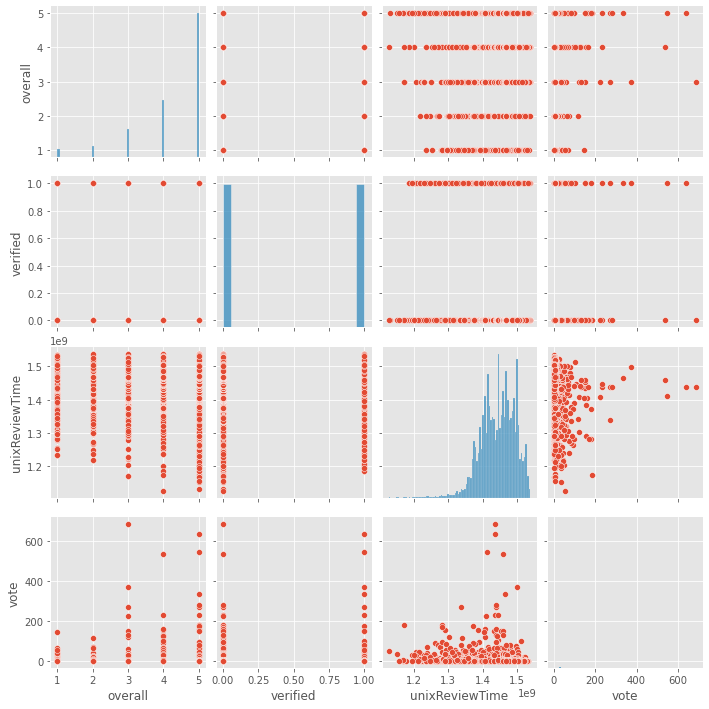

In [24]:
import seaborn as sns
sns.pairplot(df);
#unixreviewtime not converted

In [ ]:
sns.pairplot(df)
#unixreviewtime converted to year

#is it possible to plot date? last cell throws error. i think it's bc of the dashes in dates

In [25]:
df['overall'].value_counts()

5    19129
4     7593
3     3764
2     1496
1     1095
Name: overall, dtype: int64

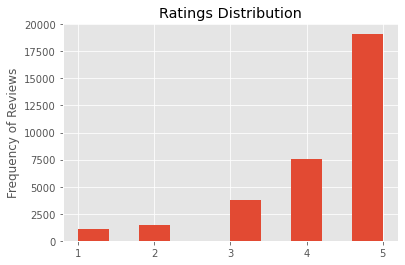

In [26]:
#distribution of ratings
fig, ax = plt.subplots()
ax.hist(df['overall'], bins=10)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('Frequency of Reviews')
ax.set_title('Ratings Distribution');
# more 5 stars given -- skewed

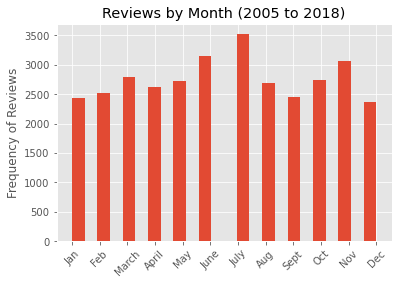

In [27]:
#frequency of reviews by month
fig, ax = plt.subplots()
ax.hist(pd.to_datetime(df['unixReviewTime'],unit='s').dt.month, bins=24)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], rotation=45)
ax.set_ylabel('Frequency of Reviews')
ax.set_title('Reviews by Month (2005 to 2018)');
# more beauty product reviews in the spring around March, summer around June and July, 
# and in the fall around black friday/thanksgiving in November

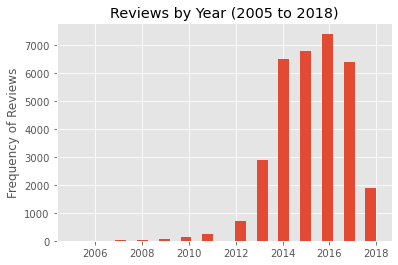

In [28]:
#frequency of reviews by year
fig, ax = plt.subplots()
ax.hist(pd.to_datetime(df['unixReviewTime'],unit='s').dt.year, bins=28)
# ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
# ax.set_xticklabels(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], rotation=45)
ax.set_ylabel('Frequency of Reviews')
ax.set_title('Reviews by Year (2005 to 2018)');
# more reviews starting 2013 and beyond
# 2018 looks low but that's because we stopped collection in september 2018 -- not full year

In [ ]:
# verified by rating
grouped = df.groupby(['verified'])
verified = []
avg_ratings = []
for category_name,category_df in grouped:
#     print(category_df)
    
    avg_ratings.append(category_df['overall'].mean())
    verified.append(category_name)
# plt.plot(pd.to_datetime(df['unixReviewTime'],unit='s').dt.month, df['overall']);
avg_ratings
verified

## Text Processing

In [40]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

#apply remove_accents fxn
#gave a lot of errors until i applied to_string on reveiwText above!
df['processed_text'] = df['reviewText'].transform(remove_accents)
#remove ellipses
df['processed_text'] = df['processed_text'].replace('\.+','.',regex=True)
df['processed_text'].head()

0    This handcream has a beautiful fragrance. It d...
1    wonderful hand lotion, for seriously dry skin,...
2    Best hand cream around.  Silky, thick, soaks i...
3                                             Thanks!!
4    Great hand lotion.  Soaks right in and leaves ...
Name: processed_text, dtype: object

In [30]:
df.head()

overall  verified reviewTime      reviewerID        asin  \
0        5      True 2018-01-05  A2HOI48JK8838M  B00004U9V2   
1        5      True 2017-04-05  A1YIPEY7HX73S7  B00004U9V2   
2        5      True 2017-03-27  A2QCGHIJ2TCLVP  B00004U9V2   
3        5      True 2017-03-20  A2R4UNHFJBA6PY  B00004U9V2   
4        5      True 2017-02-28  A2QCGHIJ2TCLVP  B00004U9V2   

                   style     reviewerName  \
0  {'Size:': ' 0.9 oz.'}               DB   
1  {'Size:': ' 3.5 oz.'}            Ajaey   
2    {'Size:': ' 250 g'}         D. Jones   
3  {'Size:': ' 3.5 oz.'}  Amazon Customer   
4  {'Size:': ' 0.9 oz.'}         D. Jones   

                                          reviewText                 summary  \
0  This handcream has a beautiful fragrance. It d...     Beautiful Fragrance   
1  wonderful hand lotion, for seriously dry skin,...   wonderful hand lotion   
2  Best hand cream around.  Silky, thick, soaks i...  Best hand cream around   
3                                           Thanks!!              Five Stars   
4  Great hand lotion.  Soaks right in and leaves ...      Great hand lotion!   

   unixReviewTime  vote image  \
0      1515110400   NaN   NaN   
1      1491350400   NaN   NaN   
2      1490572800   NaN   NaN   
3      1489968000   NaN   NaN   
4      1488240000   NaN   NaN   

                                      processed_text  
0  This handcream has a beautiful fragrance. It d...  
1  wonderful hand lotion, for seriously dry skin,...  
2  Best hand cream around.  Silky, thick, soaks i...  
3                                           Thanks!!  
4  Great hand lotion.  Soaks right in and leaves ...

In [41]:
tokens = [sent for sent in map(word_tokenize, df['processed_text'])]

list(enumerate(tokens))

[(0,
  ['This',
   'handcream',
   'has',
   'a',
   'beautiful',
   'fragrance',
   '.',
   'It',
   'doesnt',
   'stay',
   'on',
   'or',
   'protect',
   'your',
   'hands',
   'through',
   'washing',
   '.',
   'This',
   'size',
   'is',
   'quite',
   'small',
   '.']),
 (1,
  ['wonderful',
   'hand',
   'lotion',
   ',',
   'for',
   'seriously',
   'dry',
   'skin',
   ',',
   'stays',
   'on',
   'a',
   'long',
   'time',
   ',',
   'a',
   'little',
   'goes',
   'a',
   'long',
   'long',
   'way',
   '.',
   'go',
   'easy',
   '.',
   'wonderful',
   'scent',
   '.',
   'maybe',
   'a',
   'bit',
   'strong',
   'at',
   'first',
   ',',
   'but',
   'dissipates',
   'after',
   'a',
   'while',
   '.']),
 (2,
  ['Best',
   'hand',
   'cream',
   'around',
   '.',
   'Silky',
   ',',
   'thick',
   ',',
   'soaks',
   'in',
   'all',
   'the',
   'way',
   'leaving',
   'hands',
   'super',
   'soft',
   '.']),
 (3, ['Thanks', '!', '!']),
 (4,
  ['Great',
   'hand',
   

In [42]:
tokens_lower = [[word.lower() for word in sent]
                 for sent in tokens]

In [43]:
stopwords_ = set(stopwords.words('english'))

In [44]:
punctuation_ = set(string.punctuation)
print("--- punctuation: {}".format(string.punctuation))

--- punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [45]:
def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_])

tokens_filtered = list(map(filter_tokens, tokens_lower))

for sent in tokens_filtered:
    print("--- sentence tokens: {}".format(sent))

--- sentence tokens: ['handcream', 'beautiful', 'fragrance', 'doesnt', 'stay', 'protect', 'hands', 'washing', 'size', 'quite', 'small']
--- sentence tokens: ['wonderful', 'hand', 'lotion', 'seriously', 'dry', 'skin', 'stays', 'long', 'time', 'little', 'goes', 'long', 'long', 'way', 'go', 'easy', 'wonderful', 'scent', 'maybe', 'bit', 'strong', 'first', 'dissipates']
--- sentence tokens: ['best', 'hand', 'cream', 'around', 'silky', 'thick', 'soaks', 'way', 'leaving', 'hands', 'super', 'soft']
--- sentence tokens: ['thanks']
--- sentence tokens: ['great', 'hand', 'lotion', 'soaks', 'right', 'leaves', 'skin', 'super', 'soft', 'greasy', 'residue', 'great', 'scent']
--- sentence tokens: ['great', 'product', "n't", 'leave', 'hands', 'feeling', 'greasy', 'slippery']
--- sentence tokens: ['great', 'product', "n't", 'leave', 'hands', 'feeling', 'greasy', 'slippery']
--- sentence tokens: ['described', 'arrived', 'time']
--- sentence tokens: ['nice', 'lightweight', 'hand', 'cream', 'summer']
--- s

--- sentence tokens: ['great']
--- sentence tokens: ['liking', 'lot', 'since', 'using', 'pca', 'products', 'rarely', 'get', 'break', 'outs']
--- sentence tokens: ['good', 'cleanser', 'gentle', 'thorough', 'used', 'years', 'continue', 'use', 'love']
--- sentence tokens: ['like', 'use', 'product', 'morning', "'s", 'good', 'removing', 'makeup', 'evening', 'leaves', 'skin', 'feeling', 'clean', 'refreshed', 'would', 'suggest', 'dry', 'skin']
--- sentence tokens: ['great', 'facial', 'wash111']
--- sentence tokens: ["'ve", 'using', 'pca', 'facial', 'wash', 'phaze', '1', 'year', 'love', 'way', 'cleans', 'makeup', 'without', 'drying', 'skin']
--- sentence tokens: ['review', '``', 'handy', "''", 'medium', 'sized', 'mason', 'pearson', 'brush', 'made', 'six', 'rings', 'mixed', 'boar', 'bristle', 'nylon', 'longer', 'bristles', 'nylon', 'shorter', 'ones', 'boar', 'bristle', 'beautiful', 'heirloom', 'brush', 'worth', 'every', 'penny', 'incredibly', 'high', 'price', 'larger', 'mason', 'pearson', 'brus

--- sentence tokens: ['wanted', 'wait', 'review', 'three', 'months', 'feel', 'comfortable', 'first', 'say', "'m", '``', 'new', '``', 'world', 'shaving', 'cream', '30', 'years', "'ve", 'used', 'dry', 'electric', 'razor', 'christmas', 'decided', 'treat', 'new', 'panasonic', 'wet/dry', 'shaver', 'decided', 'go', 'way', 'shaving', 'cream', 'even', 'brush', 'love', 'shaver', 'different', 'review', 'tried', 'times', 'dry', 'nothing', 'special', 'cream', "'s", 'amazingly', 'close', 'uncomfortable', 'cream', 'feels', 'really', 'good', 'rinses', 'easy', 'easy', 'rinse', 'shaver', 'biggest', 'question', 'price', 'seemed', 'expensive', 'however', "'ve", 'used', 'almost', '4', 'months', 'still', 'probably', 'another', 'month', 'left', 'really', "'m", 'still', 'trying', 'use', 'little', 'possible', 'could', 'still', 'use', 'less', 'tiniest', 'amount', 'tip', 'brush', 'lathers', 'really', 'well', 'might', 'try', 'others', 'like', 'far', "n't", 'felt', 'silly', 'spending', 'much', 'shaving', 'almost'

--- sentence tokens: ['must', 'use', 'toppik', 'sure', "n't", 'package', 'product', 'guess', "'s", 'keep', 'costs']
--- sentence tokens: ['maybe', "'m", 'wrong', "n't", 'work', 'blows', 'product', 'hair']
--- sentence tokens: ['waste', 'money']
--- sentence tokens: ['spreads', 'product', 'evenly', 'area', 'every', 'uses', 'turn', 'applicator', 'upside', '``', 'fluff', "''", 'fibers', 'inside', 'keeps', 'product', 'spraying', 'evenly', 'concentrated', 'one', 'spot']
--- sentence tokens: ['like', 'product', 'looking', 'easier', 'way', 'apply', 'instead', 'shaking', 'thought', 'solution', 'fit', 'canister', 'even', 'bulb', 'type', 'spray', 'would', 'hard', 'use', 'fit', 'canister']
--- sentence tokens: ['although', 'like', 'product', 'ordered', 'like', 'product', 'helps', 'keep', 'fibers', 'want', 'go', 'however', 'think', 'pricey', 'get']
--- sentence tokens: ['spray', 'applicator', 'great', 'addition', 'use', 'fibers', 'would', 'much', 'rather', 'spray', 'shake', 'manage', 'either', 'wa

--- sentence tokens: ['hair', 'stylist', 'recommended', 'hair', 'dryer', 'satisfied', 'light', 'weight', 'extra', 'long-', 'heavy', 'duty', 'cord', '3', 'fan', '3', 'heat', 'settings', "'ve", 'owned', 'pricey', 'dryers', 'far', 'best']
--- sentence tokens: ['howdy', 'cowboy', 'love', 'man', 'house', 'uses', 'shaving', 'gel', "'s", 'fragrance', 'fresh', 'manly', 'much', 'wo', "n't", 'sneak', 'use', 'foams', 'nicely', 'allows', 'nice', 'clean', 'shave', 'leaving', 'smooth', 'skin', 'without', 'irritation', 'subsequent', 'bumps', 'yes', 'make', 'think', 'sexy', 'marlboro', 'man', 'without', 'stinky', 'cigarettes', 'howdy', 'cowboy']
--- sentence tokens: ['husband', 'using', 'shaving', 'gel', 'past', 'week', 'really', 'likes', "'s", 'gentle', 'sensitive', 'skin', 'provides', 'nice', 'clean', 'shave', 'pump', 'dispenser', 'works', 'nicely', 'dispenses', 'right', 'amount', 'full', 'shave', 'face', 'neck']
--- sentence tokens: ['creamy', 'nice', 'scent', 'use', 'little', 'works', 'well', 'use

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




--- sentence tokens: ['product', 'arrived', 'afternoon', 'eagerly', 'removed', 'box', 'began', 'pump', 'away', 'totally', 'excited', 'try', 'new', 'serum', 'many', 'many', 'pumps', 'nothing', 'happened', 'took', 'top', 'instantly', 'noticed', '``', 'straw', "''", 'connects', 'pump', 'missing', 'explains', 'amount', 'pumping', 'would', 'result', 'product', 'found', 'pack', 'chopsticks', 'junk', 'drawer', 'gave', 'contents', 'little', 'prod', 'hoping', 'locate', 'reconnect', '``', 'straw', "''", 'type', 'device', 'nothing', 'bottle', 'except', 'serum', 'way', 'get', 'thick', 'shaking', 'tapping', 'even', 'slamming', 'palm', 'resulted', 'little', 'coming', 'deduce', 'smell', 'really', 'nice', 'seems', 'lovely', 'shimmer', 'woe', 'betide', 'person', 'gets', 'bottle', 'similar', 'mine', 'work', 'idea', 'even', 'get', 'bottle', 'weird', 'quality-control', 'issue', 'locate', 'way', 'get', 'bottle', 'without', 'contaminating', 'update', 'review']
--- sentence tokens: ['face', 'looks', 'less',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



--- sentence tokens: ['first', 'experience', 'vichy', 'skin-care', 'products', 'skin', 'normal', 'oily', 'dry', 'applied', 'light', 'scented', 'mask', 'taking', 'morning', 'shower', 'left', '5', 'minutes', 'suggest', 'gel', 'feels', 'little', 'sticky', 'like', 'typical', 'mask', 'leave', '10-15', 'minutes', 'wash', 'probably', 'would', 'work', 'really', 'well', 'dry', 'skin', 'gave', 'zit', 'forehead', 'highly', 'unusual', 'pass', 'daughter', 'dry', 'skin', 'see', 'thinks', 'likes', 'edit', 'review', '4', 'stars']
--- sentence tokens: ['reviewers', 'leaving', 'dries', 'and/or', 'complaining', 'sticky', 'using', 'incorrectly', 'granted', 'directions', 'box', 'jar', 'look', 'product', 'description', 'google', 'product', 'tells', "''", 'gently', 'apply', 'skin', 'leave', '5', 'minutes', 'wipe', 'away', 'face', 'mask', 'cotton', 'pad', 'rinsing', 'required', "''", 'followed', 'instructions', 'like', 'light', 'scent', 'could', 'without', 'cooling', 'sensation', "'m", 'sensitive', 'lot', 'sk

--- sentence tokens: ['amazing', 'eyes', 'first', 'dot', 'lightly', 'use', 'beauty', 'blender', 'make-up', 'sponge', 'gently', 'blend', 'use', 'less', 'typically', 'would', 'products', 'thoroughly', 'covers', 'need', 'touch', 'add', 'bare', 'minimum', 'blend', 'use', 'dermablend', 'foundation', 'uniform', 'color', 'apply', 'less', 'typically', 'would', 'blend', 'blend', 'blend', 'results', 'gorgeous', 'look', 'appear', 'natural', 'polished', 'long', 'use', 'minimum', 'blend', 'needed', 'dermablend', 'easily', 'one', 'best', 'products', 'market', 'used', 'line', 'years', 'years', 'love', 'highly', 'recommended']
--- sentence tokens: ['dermablend', 'concealer', 'easy', 'apply', 'goes', 'n', 'smoothly', 'particle', 'color', 'little', 'lighter', 'expected', 'job', 'concealing', 'circles', 'eyes', 'occasional', 'adult', 'acne', 'hot', 'humid', 'weather', 'southern', 'florida', 'concealer', 'surprisingly', 'enough', 'needed', 'reapplied', 'found', 'big', 'plus', 'gave', 'one', 'less', 'star'

### Bag of Words

In [49]:
stemmer_snowball = SnowballStemmer('english')
tokens_stemsnowball = [list(map(stemmer_snowball.stem, sent)) for sent in tokens_filtered]
print("--- sentence tokens (snowball): {}".format(tokens_stemsnowball[24]))
#'data-hook=', "''", 'product-link-link', "''", 
#'class=', "''", 'a-link-norm', "''", 'href=', "''", 
#'/angela-s-garden-7120-921-kids-garden-glove-honey-bee/dp/b000p8dhqg/ref=cm_cr_arp_d_rvw_txt',
#'ie=utf8'

#^^^ info from images was left in... remove href?
# There are 479 instances -- not much so may not be important

--- sentence tokens (snowball): ['hand', 'cream', 'one', 'nicest', 'fragranc', 've', 'ever', 'come', 'across', 'seem', 'one', 'everybodi', 'like', 'cream', 'non', 'greasi', 'absorb', 'quick', 'leav', 'hand', 'feel', 'soft', 'moistur', 'product', 'buy', 'sever', 'year', 'also', 'make', 'nice', 'gift', 'basket', 'pair', 'nbsp', 'data-hook=', "''", 'product-link-link', "''", 'class=', "''", 'a-link-norm', "''", 'href=', "''", '/angela-s-garden-7120-921-kids-garden-glove-honey-bee/dp/b000p8dhqg/ref=cm_cr_arp_d_rvw_txt', 'ie=utf8', "''", 'angela', "'s", 'garden', '7120-921', 'kid', 'garden', 'glove', 'honey', 'bee', '/a', 'hand', 'garden', 'tool', 'coupl', 'packet', 'seed', 'peopl', 'given', 'tell', "'s", 'becom', 'one', 'favorit', 'everyon', 'seem', 'like', "'s", 'nice', 'clean', 'smell']


In [ ]:
# n-grams: bigrams and trigrams

## TFIDF and SVM

In [ ]:
from collections import Counter
#go through bag of words and count occurrence of each keyword
# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), tokens_stemsnowball))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(tokens_stemsnowball[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]['reviewText']))
    print("--- bow: {}".format(bows[i]))
    print("--- term_occ: {}".format(term_occ[i]))
    print("--- term_freq: {}".format(term_freq[i]))